# Data Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

# Data Preparation

In [4]:
# Import Data
df = pd.read_csv("../Thesis Data/Q1_clean.csv")

In [5]:
print('{} total loans, {:.4%} defaulted'.format(df.shape[0], np.mean(df['Default'])))

479862 total loans, 0.0129% defaulted


In [6]:
# Reset index to Loan ID
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('SellerName', axis=1, inplace=True)
df.drop('ProductType', axis=1, inplace=True)
df.set_index('LoanID', inplace=True)

In [7]:
df.columns.values

array(['Channel', 'OrInterestRate', 'OrUPB', 'OrLoanTerm', 'OrDate',
       'FirstPayDate', 'OrLTV', 'OrCLTV', 'NumBorrow', 'OrDTIRat',
       'OrCreditScore', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType',
       'NumUnits', 'OccStatus', 'PropertyState', 'Zip', 'MortInsPerc',
       'CoCreditScore', 'MortInsType', 'RelMortInd', 'Default',
       'CoCreditor'], dtype=object)

# SMOTE
Synthetic Minority Oversampling Technique
- over-smaple minority
- under-sample majority
- create synthetic data for the minority

In [8]:
# ===================================================================================
# Function Name: cat_smote
# Currently the SMOTE library does not support categorical variables well. This 
# function finds the categorical variables, converts to integers, uses the SMOTE
# function, and then converts the rounded values back to categorical variables.
# ===================================================================================

from imblearn.combine import SMOTEENN as smote

def cat_smote(data, y_var, unique_cap = 15):
    # Identify columns with numerical values
    nums = data._get_numeric_data()
    # Initiate list to identify categorical columns stored as numeric
    nums_to_cat = []
    for i in nums:
        if nums[i].nunique() < unique_cap: # This is a lazy hack.
            nums_to_cat.append(i)
    # Store categorical data
    cats = data.drop(nums.drop(nums_to_cat, axis=1), axis=1)
    # Store categorical mappings
    cats = cats.astype('category')
    mappings = {}
    for i in cats:
        mappings.update({i: cats[i].cat.categories})
        # Convert all values to numeric
        data[i] = cats[i].cat.codes
    data = data.astype('float')
    # Resample the data
    y = data[y_var].values
    X = data.drop(y_var, axis=1).values
    sm = smote(random_state=13)
    X_smoted, y_smoted = sm.fit_sample(X, y)
    # Package as dataframe and return
    X = pd.DataFrame(X_smoted, columns=data.drop(y_var, axis=1).columns.values)
    y = pd.DataFrame(y_smoted, columns=[y_var])
    
    data = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    # Convert data back to categorical data
    for i in cats.columns:
        data[i] = [mappings.get(i)[round(x)] for x in data[i]]
    return(data)

# Train-Test Split

In [9]:
X = df.drop('Default', axis=1)
y = df['Default'].values

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=13, shuffle=False)

# Create training dataframe
X_train = pd.DataFrame(X_train, columns=df.drop('Default', axis=1).columns.values)
y_train = pd.DataFrame(y_train, columns=['Default'])
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Creating testing dataframe
X_test = pd.DataFrame(X_test, columns=df.drop('Default', axis=1).columns.values)
y_test = pd.DataFrame(y_test, columns=['Default'])
df_test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# SMOTE the training set, and get the X's and y's
df_smoted = cat_smote(df_train, y_var='Default')

In [10]:
print('Balanced Dataset: {} total loans, {:.4%} defaulted'.format(df_smoted.shape[0], np.mean(df_smoted['Default'])))

Balanced Dataset: 474132 total loans, 50.2622% defaulted


Because this dataset is simply too large for me to pull off cross validation I take a subset of it at 2.5% of the original smote data set. I then use the cross-validated hyper-parameters to train the model on the full smote data set.

In [11]:
X_smoted = df_smoted.drop('Default', axis=1)
y_smoted = df_smoted['Default'].values

X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smoted, y_smoted, test_size=0.975, random_state=13)

X_smote_train = pd.DataFrame(X_smote_train, columns=df.drop('Default', axis=1).columns.values)
y_smote_train = pd.DataFrame(y_smote_train, columns=['Default'])

df_smote_train = pd.concat([X_smote_train.reset_index(drop=True), y_smote_train.reset_index(drop=True)], axis=1)

print('Balanced Dataset: {} total loans, {:.4%} defaulted'.format(df_smote_train.shape[0], np.mean(df_smote_train['Default'])))

Balanced Dataset: 11853 total loans, 50.5273% defaulted


For sake of reducing computational energy and time, I will be avoiding categorical data completely.

In [12]:
cat_vars=['Channel', 'FirstPayDate', 'NumBorrow', 'FTHomeBuyer', 
          'LoanPurpose', 'PropertyType', 'NumUnits', 'OccStatus', 
          'PropertyState', 'Zip', 'MortInsType', 'OrDate', 'RelMortInd']

In [13]:
y_smote_train = y_smote_train['Default']
y_test = y_test['Default']

X_smote_train = X_smote_train.drop(cat_vars, axis=1)
X_smoted = X_smoted.drop(cat_vars, axis=1)
X_test = X_test.drop(cat_vars, axis=1)

# Algorithms and Evaluation

## Evaluation Functions

In [22]:
from sklearn.model_selection import GridSearchCV

In [15]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(X_train, y_train, X_test, y_test, clf):
    # Fit and Predict
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(1, figsize=(15, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
# PR Curve
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(X_train, y_train, X_test, y_test, clf):
    # Fit and Predict
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
    pr_auc = auc(recall, precision)
    fig, ax = plt.subplots(1, figsize=(15, 10))
    plt.plot(recall, precision, color='darkorange', lw=1, label='PR curve (area = %0.2f)' % pr_auc)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

## Logistic Regression
[Tutorial](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [80]:
logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(X_smote_train, y_smote_train)

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


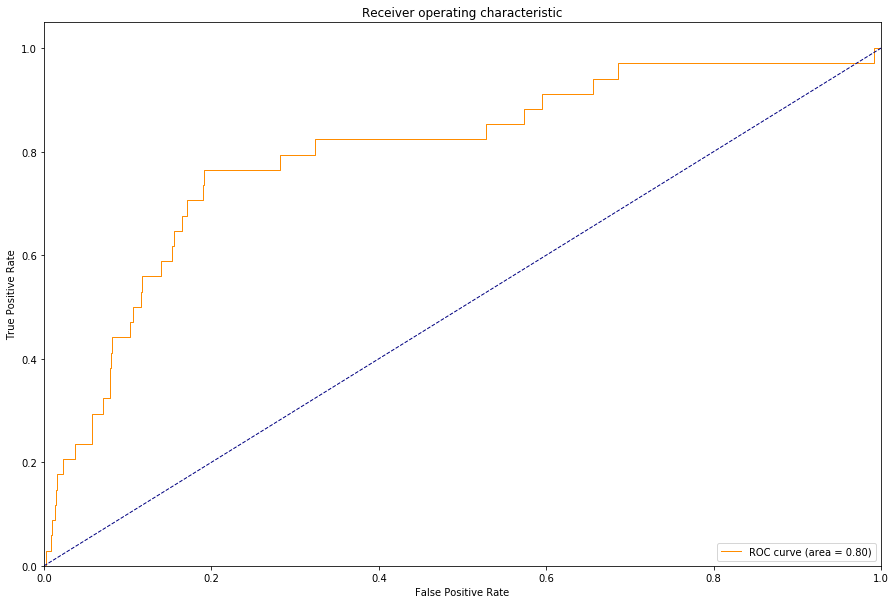

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[1.42952645e-04 1.38748739e-04 1.38749322e-04 ... 0.00000000e+00
 0.00000000e+00 1.00000000e+00]
[1.         0.97058824 0.97058824 ... 0.         0.         0.        ]
[0.00207318 0.00207328 0.00207346 ... 0.97670719 0.97695065 0.97828818]


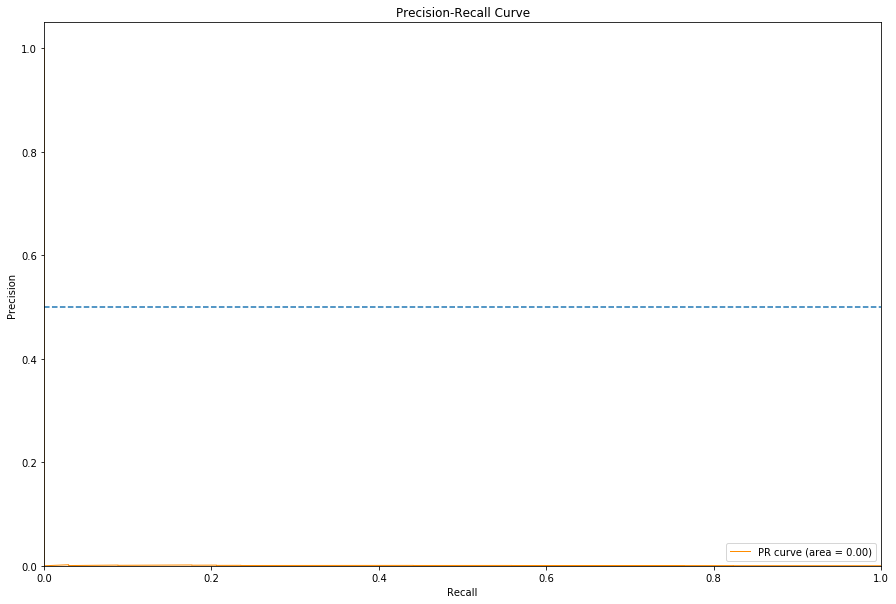

In [86]:
logreg = LogisticRegression(solver='lbfgs')

plot_roc_curve(X_smoted_num, y_smoted, X_test_num, y_test, logreg)
plot_pr_curve(X_smoted_num, y_smoted, X_test_num, y_test, logreg)

## K-Nearest Neighbor
Introduce CV to tune hyper-parameters...

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn_param_grid = {'n_neighbors': np.arange(20, 100)}

knn_gscv = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)

knn_gscv = knn_gscv.fit(X_smote_train, y_smote_train)

print(knn_gscv.best_score_)
print(knn_gscv.best_params_)

0.7223487724626677
{'n_neighbors': 20}


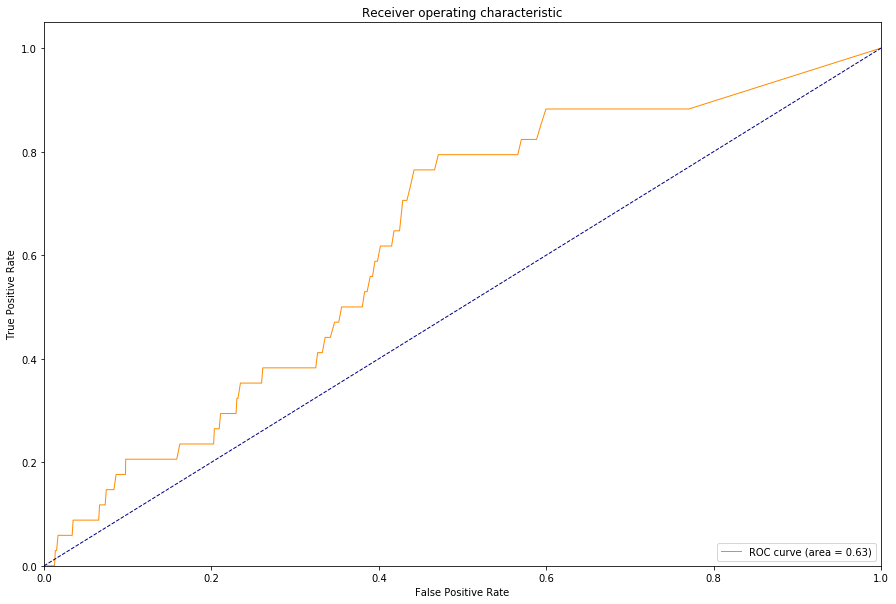

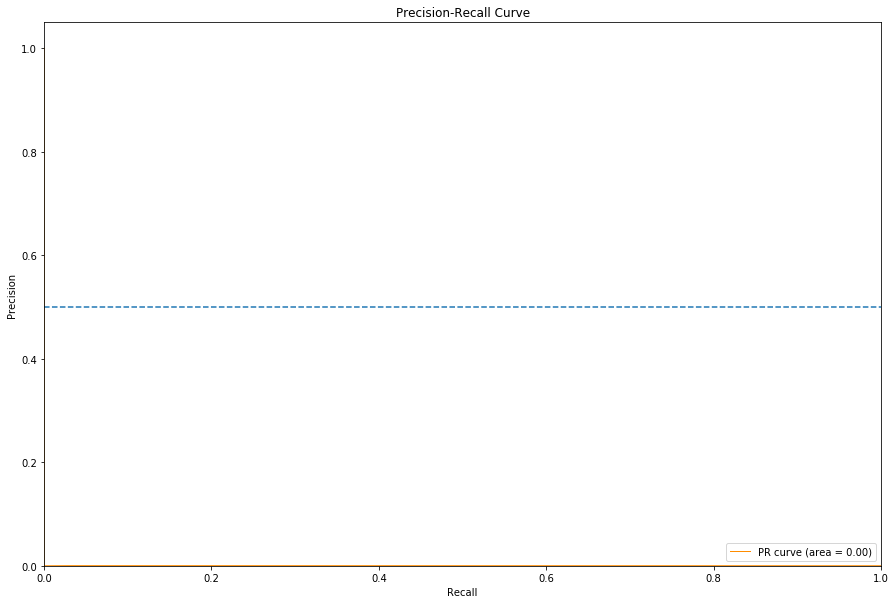

In [27]:
knn_clf = KNeighborsClassifier(n_neighbors=550)
# Cross Validation
plot_roc_curve(X_smoted, y_smoted, X_test, y_test, knn_clf)
plot_pr_curve(X_smoted, y_smoted, X_test, y_test, knn_clf)

## Random Forest
[Tutorial](https://www.kaggle.com/viczyf/titanic-random-forest-82-78)

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
# Hyper-Parameter Tuning
rf_clf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

rf_param_grid={"min_samples_leaf":[1,5,10], "min_samples_split":[2,4,8,10,16], "n_estimators":[50,75,100,125,150]}

rf_gscv = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)

rf_gscv = rf_gscv.fit(X_smote_train_num, y_smote_train)

print(rf_gscv.best_score_)
print(rf_gscv.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.9987344975955454
{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


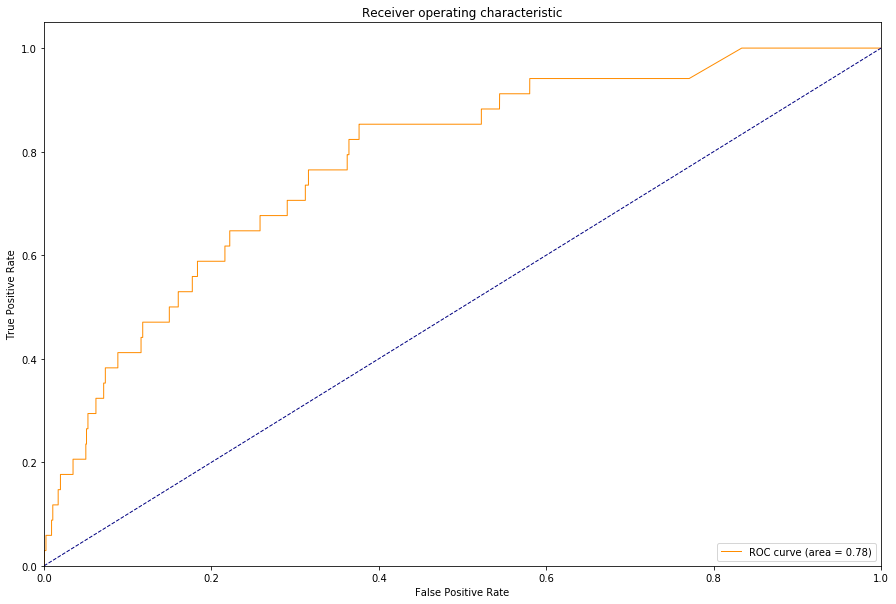

In [33]:
# Model-Training

rf_clf = RandomForestClassifier(min_samples_leaf=100, min_samples_split=100, n_estimators=2000, oob_score=True, random_state=1, n_jobs=-1)

plot_roc_curve(X_smoted, y_smoted, X_test, y_test, rf_clf)

## Gradient Boosting Machine
[Tutorial](https://www.kaggle.com/ihopethiswillfi/titanic-survival-prediction-in-python-with-xgboost)



In [35]:
from xgboost import XGBClassifier

In [74]:
xgb_clf = XGBClassifier()

xgb_param_grid = {'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5] }

xgb_gscv = GridSearchCV(estimator=xgb_clf, param_grid=xgb_param_grid, scoring='accuracy', cv=5, n_jobs=-1)

xgb_gscv = xgb_gscv.fit(X_smote_train_num, y_smote_train)

print(xgb_gscv.best_score_)
print(xgb_gscv.best_params_)

0.9979751961528727
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


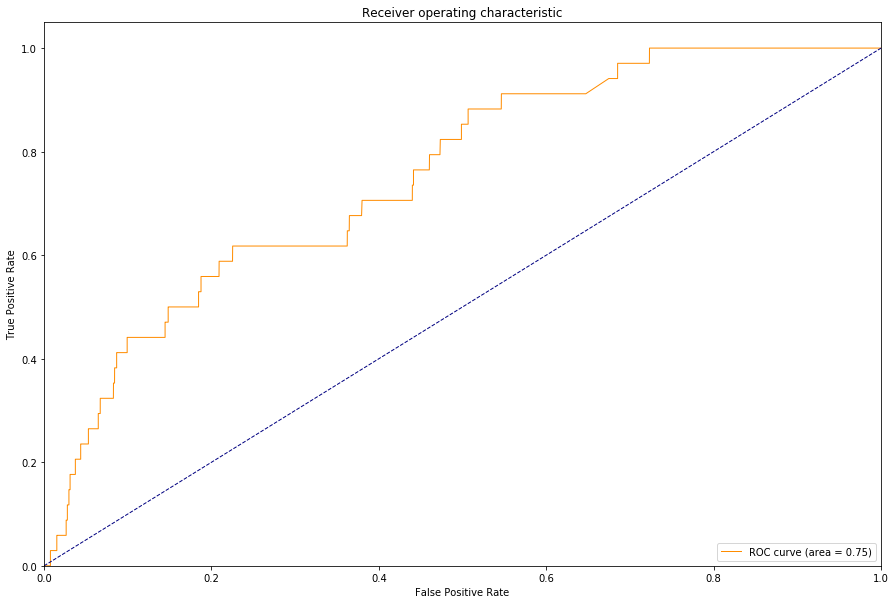

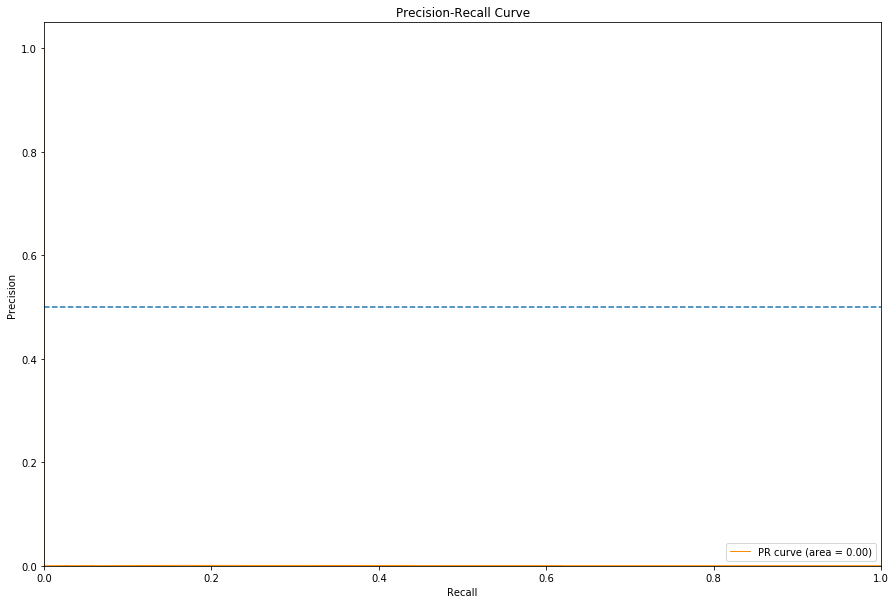

In [37]:
xgb_clf = XGBClassifier(min_child_weight=3,gamma=1,subsample=1.0, cosamply_bytree=3, max_depth=20)

plot_roc_curve(X_smoted, y_smoted, X_test, y_test, xgb_clf)
plot_pr_curve(X_smoted, y_smoted, X_test, y_test, xgb_clf)

## Support Vector Machines (SVMs)
[Tutorial](https://www.kaggle.com/l3r4nd/titanic-prediction-with-svm)

In [25]:
from sklearn.svm import SVC

lrsvm_clf = SVC(kernel='linear')
polysvm_clf = SVC(kernel='poly')
rbfsvm_clf = SVC(kernel='rbf')
sigsvm_clf = SVC(kernel='sigmoid')

svm_param_grid = {'C': [0.01, 0.1, 1], 'gamma' : [0.001, 0.01, 0.1]}

lrsvm_gscv = GridSearchCV(estimator=lrsvm_clf, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
polysvm_gscv = GridSearchCV(estimator=polysvm_clf, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rbfsvm_gsv = GridSearchCV(estimator=rbfsvm_clf, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
sigsvm_gsv = GridSearchCV(estimator=sigsvm_clf, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [26]:
lrsvm_gscv = lrsvm_gscv.fit(X_smote_train_num, y_smote_train)
print(lrsvm_gscv.best_params_)

KeyboardInterrupt: 

In [ ]:
lrsvm_clf = SVC(kernel='linear', C=1)

plot_roc_curve(X_smoted_num, y_smoted, X_test_num, y_test, lrsvm_clf)

In [ ]:
polysvm_gscv = polysvm_gscv.fit(X_smote_train_scaled, y_smote_train)
print(polysvm_gscv.best_params_)

In [ ]:
polysvm_clf = SVC(kernel='poly', C=1, gamma=0.001)

plot_roc_curve(X_smoted_num, y_smoted, X_test_num, y_test, polysvm_clf)

In [ ]:
rbfsvm_gsv = rbfsvm_gsv.fit(X_smote_train_num, y_smote_train)
print(rbfsvm_gsv.best_params_)

In [ ]:
rbfsvm_clf = SVC(kernel='rbf', C=1, gamma=0.1)

plot_roc_curve(X_smoted_num, y_smoted, X_test_num, y_test, rbfsvm_clf)

In [ ]:
sigsvm_gsv = sigsvm_gsv.fit(X_smote_train_num, y_smote_train)
print(sigsvm_gsv.best_params_)

In [ ]:
sigsvm_clf = SVC(kernel='sigmoid', C=1, gamma=0.001)

plot_roc_curve(X_smoted_num, y_smoted, X_test_num, y_test, sigsvm_clf)